In [12]:
import numpy as np
import pandas as pd

import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

In [14]:
data = pd.read_csv("data_2/supply.csv")

In [15]:
target = data.iloc[:, -1]
data = data.iloc[:, :-1]

In [16]:
data.head()

,Unnamed: 0,temp_max,temp_mean,temp_min,rain,is_rain,ws_max,ws_mean,ws_min,humid_max,...,vis_max,vis_mean,vis_min,month,weekday,LNG,Oil,Coal,KOSPI,KOSDAQ
0,2018-02-01,8.7,1.27,-11.3,2.5,1,12.7,3.52,0.0,99.9,...,2000.0,1552.10,500.0,2.0,3.0,57.86,65.80,1.07,2568.54,908.20
1,2018-02-02,9.2,0.42,-12.3,0.0,0,13.6,3.85,0.0,99.8,...,2000.0,1988.76,1133.0,2.0,4.0,56.01,65.45,1.02,2525.39,899.47
2,2018-02-03,5.9,-1.79,-13.9,229.7,1,19.8,5.60,0.0,99.9,...,2000.0,1427.20,157.0,2.0,5.0,54.99,64.15,1.02,2491.75,858.22
3,2018-02-04,2.7,-3.87,-15.3,220.6,1,20.2,5.98,0.7,99.9,...,2000.0,1330.41,18.0,2.0,6.0,54.99,64.15,1.02,2491.75,858.22
4,2018-02-05,4.2,-2.73,-14.4,192.8,1,17.6,5.13,0.1,99.9,...,2000.0,1355.82,19.0,2.0,0.0,54.99,64.15,1.05,2491.75,858.22


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   730 non-null    object 
 1   temp_max     730 non-null    float64
 2   temp_mean    730 non-null    float64
 3   temp_min     730 non-null    float64
 4   rain         730 non-null    float64
 5   is_rain      730 non-null    int64  
 6   ws_max       730 non-null    float64
 7   ws_mean      730 non-null    float64
 8   ws_min       730 non-null    float64
 9   humid_max    730 non-null    float64
 10  humid_mean   730 non-null    float64
 11  humid_min    730 non-null    float64
 12  vaporP_mean  730 non-null    float64
 13  dew_min      730 non-null    float64
 14  landP_max    730 non-null    float64
 15  landP_mean   730 non-null    float64
 16  landP_min    730 non-null    float64
 17  suntime      730 non-null    float64
 18  rad_mean     730 non-null    float64
 19  snow    

In [18]:
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data = data.rename(columns={'Unnamed: 0': 'date'})

In [19]:
data['week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [20]:
data = pd.concat([data, target], axis=1)

In [21]:
data.index = data.date
data = data.drop('date', axis = 1)

## XG-Boost: Feature Selection

https://www.kaggle.com/ashishpatel26/predict-sales-price-using-xgboost?select=Submission_Predict+Sales.csv

In [22]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [23]:
# supply
X, y = data.iloc[:,:-1], data.iloc[:,-1]

In [24]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [26]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.4, learning_rate = 0.02,
                max_depth = 20, alpha = 15, n_estimators = 1000)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE supply: %f" % (rmse))

RMSE supply: 2.724128


In [28]:
index = pd.date_range(y_test.index[0], y_test.index[-1])
columns = []

smp_supply_pred = pd.DataFrame(index=index, columns=columns)
smp_supply_pred['supply_pred'] = preds
smp_supply_pred['supply_test'] = y_test

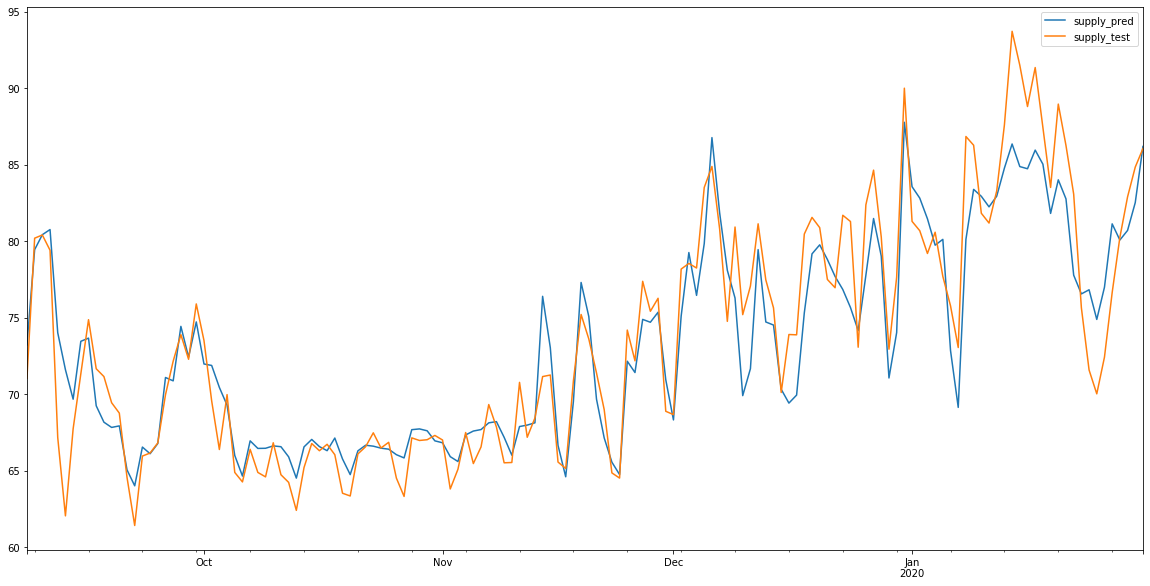

In [29]:
smp_supply_pred.plot(figsize=(20,10))

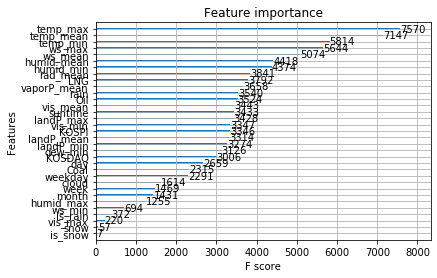

In [30]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()

In [40]:
combine = pd.concat([X, y], axis=1)

In [42]:
train = combine.copy()
test = combine.copy().drop('supply', axis=1)

In [49]:
datetimecol = test.index

In [50]:
yLabels = train['supply'] # target

In [51]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y), 
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [60]:
yLabelslog = np.log1p(yLabels)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.4, learning_rate = 0.02,
                max_depth = 20, alpha = 15, n_estimators = 1000)
xg_reg.fit(train,yLabelslog)

preds = xg_reg.predict(train)

In [61]:
print('RMSLE Value For Linear Regression: {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

RMSLE Value For Linear Regression: 0.00040161161802944854


730


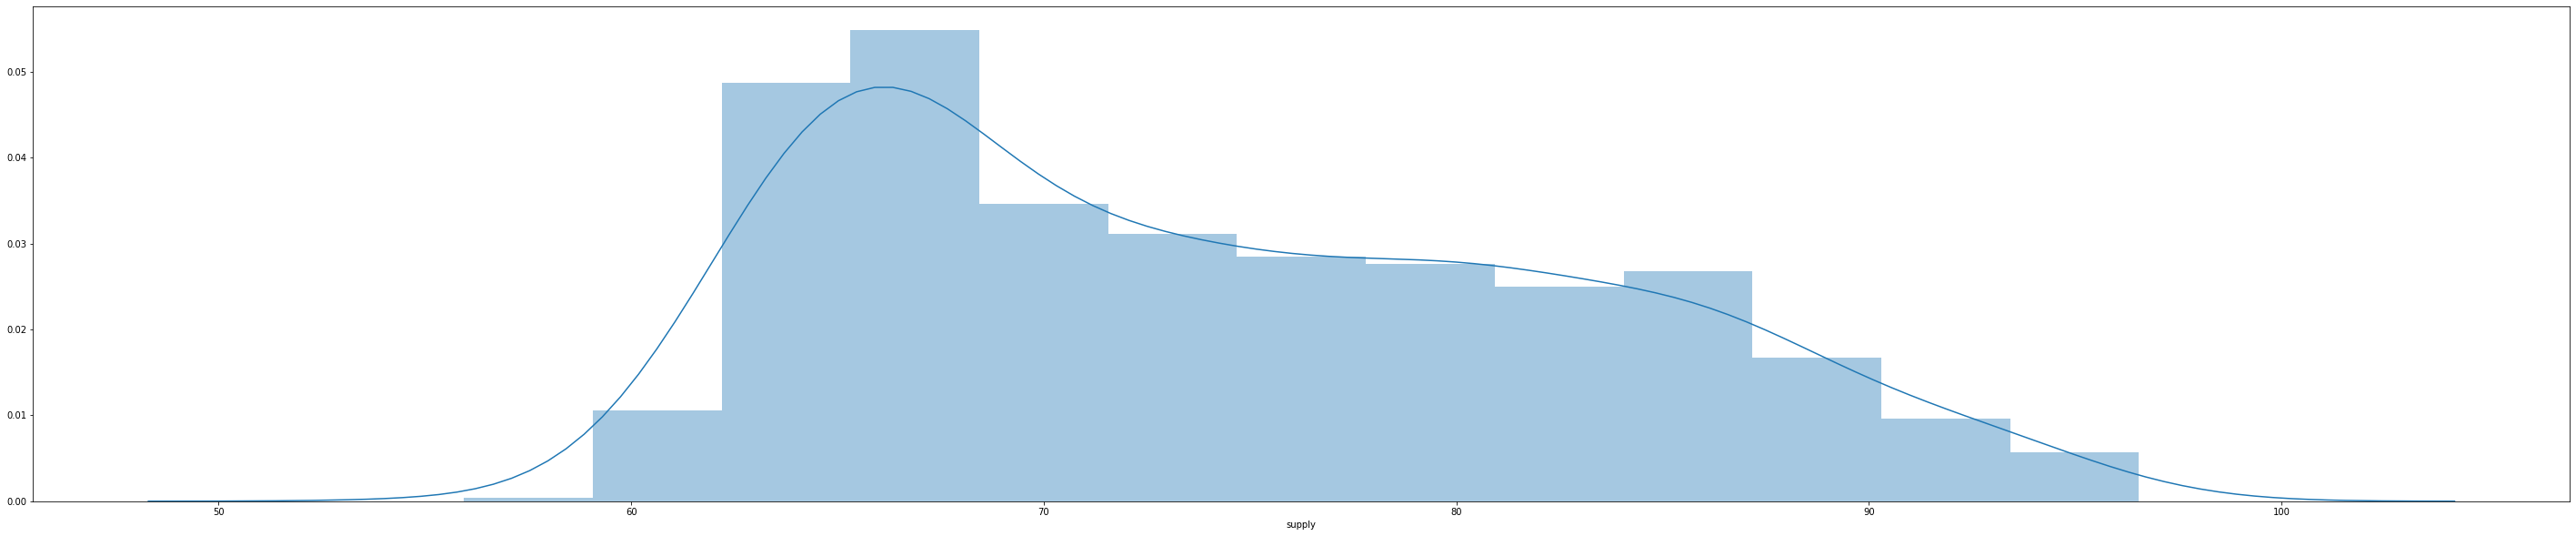

In [63]:
sns.distplot(yLabels)
print(yLabels.count()) #10886

In [66]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso


lr = LinearRegression()
yLabelslog = np.log1p(yLabels)
#선형 모델에 우리의 데이터를 학습
lr.fit(train,yLabelslog)
#결과 값 도출
preds = lr.predict(train)
#rmsle함수의 element에 np.exp()지수 함수를 취하는 이유는 우리의 preds값에 얻어진 것은 한번 log를 한 값이기 때문에 원래 모델에는 log를 하지 않은 원래의 값을 넣기 위함임.
print('RMSLE Value For Linear Regression: {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

---------------------------

In [36]:
# 과거의 feature 사용.

In [32]:
data.head()

,temp_max,temp_mean,temp_min,rain,is_rain,ws_max,ws_mean,ws_min,humid_max,humid_mean,...,month,weekday,LNG,Oil,Coal,KOSPI,KOSDAQ,week,day,supply
date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,8.7,1.27,-11.3,2.5,1,12.7,3.52,0.0,99.9,67.42,...,2,3.0,57.86,65.80,1.07,2568.54,908.20,3,1,87.47
2018-02-02,9.2,0.42,-12.3,0.0,0,13.6,3.85,0.0,99.8,57.46,...,2,4.0,56.01,65.45,1.02,2525.39,899.47,4,2,86.64
2018-02-03,5.9,-1.79,-13.9,229.7,1,19.8,5.60,0.0,99.9,76.50,...,2,5.0,54.99,64.15,1.02,2491.75,858.22,5,3,88.28
2018-02-04,2.7,-3.87,-15.3,220.6,1,20.2,5.98,0.7,99.9,79.00,...,2,6.0,54.99,64.15,1.02,2491.75,858.22,6,4,86.14
2018-02-05,4.2,-2.73,-14.4,192.8,1,17.6,5.13,0.1,99.9,77.28,...,2,0.0,54.99,64.15,1.05,2491.75,858.22,0,5,90.63


In [33]:
data_re = data.copy()
data_re.index = pd.date_range('2018-03-07', '2020-03-05')

In [34]:
data_re.tail()

,temp_max,temp_mean,temp_min,rain,is_rain,ws_max,ws_mean,ws_min,humid_max,humid_mean,...,month,weekday,LNG,Oil,Coal,KOSPI,KOSDAQ,week,day,supply
2020-03-01,12.8,7.31,-3.6,2153.8,1,20.1,6.30,0.0,99.9,90.08,...,1,0.0,59.55,53.14,0.23,2176.72,664.70,0,27,76.64
2020-03-02,12.7,6.61,-3.9,43.2,1,12.7,2.89,0.0,99.9,85.30,...,1,1.0,59.75,53.48,0.16,2176.72,664.70,1,28,80.25
2020-03-03,13.2,5.99,-5.1,204.9,1,13.6,3.81,0.0,99.9,81.52,...,1,2.0,58.88,53.33,0.16,2185.28,670.18,2,29,82.90
2020-03-04,11.5,4.75,-7.0,337.6,1,17.2,4.69,0.0,99.9,78.04,...,1,3.0,59.84,52.14,0.16,2148.00,656.39,3,30,84.85
2020-03-05,10.8,3.92,-10.5,2.5,1,13.0,3.87,0.0,99.9,69.11,...,1,4.0,59.24,51.56,NaN,2119.01,642.48,4,31,86.06


In [35]:
predic = data_re.iloc[-34:]
predic.head()

,temp_max,temp_mean,temp_min,rain,is_rain,ws_max,ws_mean,ws_min,humid_max,humid_mean,...,month,weekday,LNG,Oil,Coal,KOSPI,KOSDAQ,week,day,supply
2020-02-01,17.8,9.46,-2.6,1258.2,1,15.1,3.68,0.0,100.0,85.00,...,12,6.0,61.00,61.68,0.16,2197.67,669.83,6,29,72.94
2020-02-02,16.1,9.79,-6.0,13.9,1,18.2,4.29,0.1,99.9,81.15,...,12,0.0,61.00,61.68,0.16,2197.67,669.83,0,30,77.65
2020-02-03,10.7,0.14,-12.3,2.9,1,20.5,6.50,0.0,99.9,72.28,...,12,1.0,61.07,61.06,0.16,2175.17,674.02,1,31,90.01
2020-02-04,10.4,2.60,-6.9,0.0,0,13.0,3.54,0.1,99.9,66.06,...,1,2.0,62.32,61.18,0.16,2175.17,674.02,2,1,81.30
2020-02-05,12.5,5.38,-4.2,0.0,0,8.7,2.67,0.0,99.9,69.99,...,1,3.0,62.32,61.18,0.16,2175.17,674.02,3,2,80.69


In [24]:
target = pd.read_csv("data/target_v1.csv")
target.index = pd.to_datetime(target['date'])

In [25]:
y_df = target.supply[34:]

In [26]:
data_re = data_re.iloc[:-34]

In [27]:
X, y = data_re.iloc[:, :-1], data_re.iloc[:, -1]

In [29]:
# using previous model
data_dmatrix = xgb.DMatrix(data=X, label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE supply: %f" % (rmse))

RMSE supply: 1.905411


In [30]:
X_pred = predic.iloc[:, :-1]
preds = xg_reg.predict(X_pred)

In [60]:
data_dmatrix = xgb.DMatrix(data=X, label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.2, learning_rate = 0.3,
                max_depth = 15, alpha = 10, n_estimators = 1000)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE supply: %f" % (rmse))

RMSE supply: 4.753709


In [62]:
X_pred = predic.iloc[:, :-1]
preds = xg_reg.predict(X_pred)

In [31]:
pr = pd.DataFrame(preds)

In [32]:
pr = pr.rename(columns = {0: 'suuply'})

In [33]:
len(pr)

34

In [34]:
len(predic)

34

In [35]:
pr.index = pd.date_range('2020-02-01', '2020-03-05')

In [36]:
pr.to_csv('supply_prediction_1.csv')